In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt, freqz, firwin, lfilter
import scipy.io


In [ ]:
SAMPLE_RATE = 9000
FILE_PATH_RAW = "raw_data/normal/10Hz_accelerometer.txt"
FILE_PATH_MAT = "mat_data/notfiltered/ball/50Hz_accelerometer.mat"

In [3]:

def read_data_mat(FILE_PATH):
    Bearing_data = scipy.io.loadmat(FILE_PATH)
    label = None
    for key in Bearing_data.keys():
        if "DE_time" in key:
            label = key
            break
    return Bearing_data[label].flatten()

In [4]:
def read_data_raw(FILE_PATH_RAW):
    header = []
    data = []
    with open(FILE_PATH_RAW, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "Data as Time Sequence:":
                break
            if line:  
                header.append(line)
        
        for line in file:
            line = line.strip()
            if line:  
                try:
                    value = float(line)
                    data.append(value)
                except ValueError:
                    continue  
    return data, header

In [ ]:
def plot_signal_spectrum(signal, sampling_rate, min_x = 0.5, max_x = 30):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    half_n = n // 2
    freq = freq[:half_n]
    magnitude = magnitude[:half_n]
    plt.figure(figsize=(10, 6))
    plt.plot(freq, np.log10(magnitude))
    plt.xlim([min_x, max_x])
    plt.ylim([-3, 3])
    plt.title('Signal Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

1000


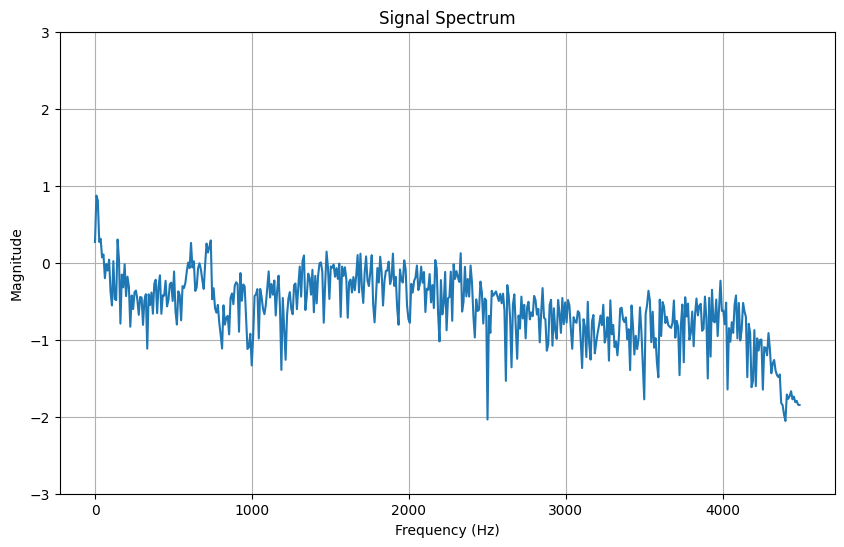

In [26]:
signal, header = read_data_raw(FILE_PATH_RAW)
signal = signal[:1000]
print(len(signal))
plot_signal_spectrum(signal, SAMPLE_RATE, 0.5, SAMPLE_RATE//2)

In [7]:
def find_peak_frequency_in_range(signal, sampling_rate, f_min, f_max):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/sampling_rate)
    fft_values = np.fft.rfft(signal)
    magnitude = np.abs(fft_values)
    mask = (freq >= f_min) & (freq <= f_max)
    freq_in_range = freq[mask]
    magnitude_in_range = magnitude[mask]
    
    if len(magnitude_in_range) == 0:
        return None, None
    max_index = np.argmax(magnitude_in_range)
    peak_frequency = freq_in_range[max_index]
    peak_amplitude = magnitude_in_range[max_index]
    return peak_frequency, peak_amplitude

In [8]:
peak_freq, peak_vibr = find_peak_frequency_in_range(signal, SAMPLE_RATE, 1, 30)
print(peak_freq, peak_vibr)


20.398413456731145 999.6591672320003


In [9]:

def butter_bandstop(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a

def butter_bandstop_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def fir_bandstop(numtaps, lowcut, highcut, fs):
    # numtaps — число коэффициентов (порядок фильтра + 1)
    taps = firwin(
        numtaps=numtaps,
        cutoff=[lowcut, highcut],
        fs=fs,
        pass_zero='bandstop'
    )
    return taps



In [10]:
lowcut = peak_freq - 2
highcut = peak_freq + 2
filtered_signal = butter_bandstop_filter(signal, lowcut, highcut, SAMPLE_RATE, order=2)

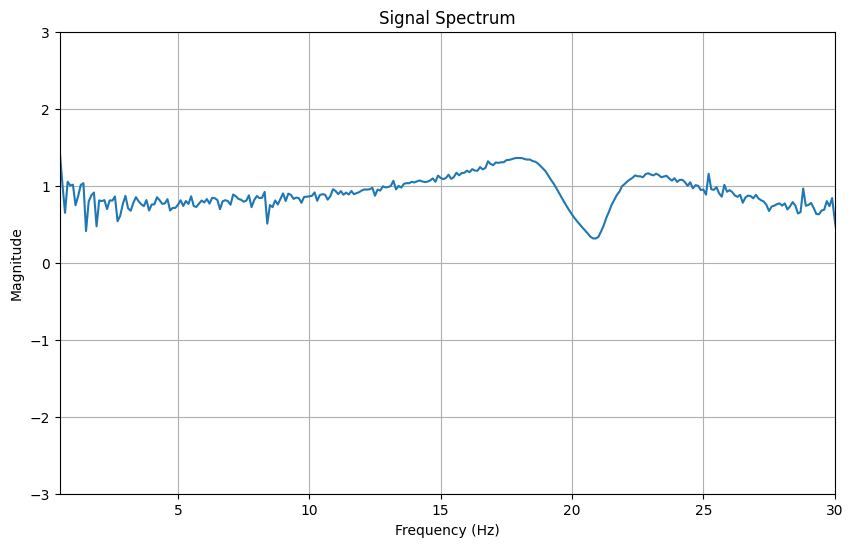

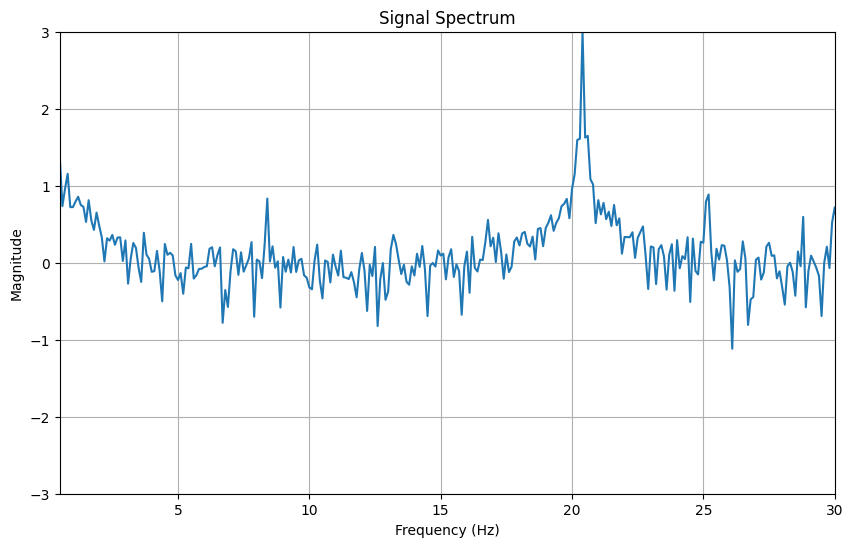

In [11]:

plot_signal_spectrum(filtered_signal, SAMPLE_RATE)
plot_signal_spectrum(signal, SAMPLE_RATE)

In [12]:
def plot_frequency_response(b, a, fs):
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h))
    plt.xlim([0, 40])
    plt.title('Frequency Response of Bandstop Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.show()

    

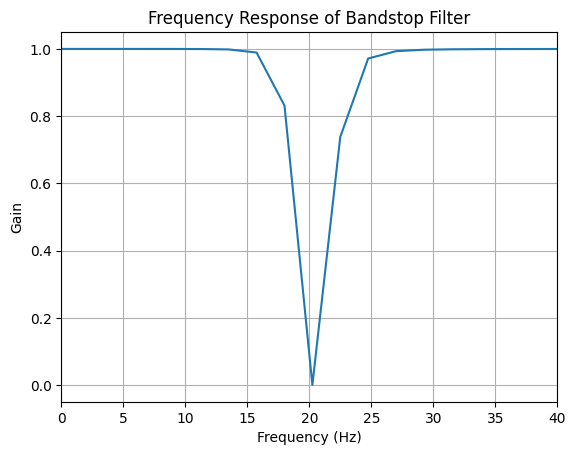

In [13]:
fs = SAMPLE_RATE  
order = 2  

b, a = butter_bandstop(lowcut, highcut, fs, order)
plot_frequency_response(b, a, fs)

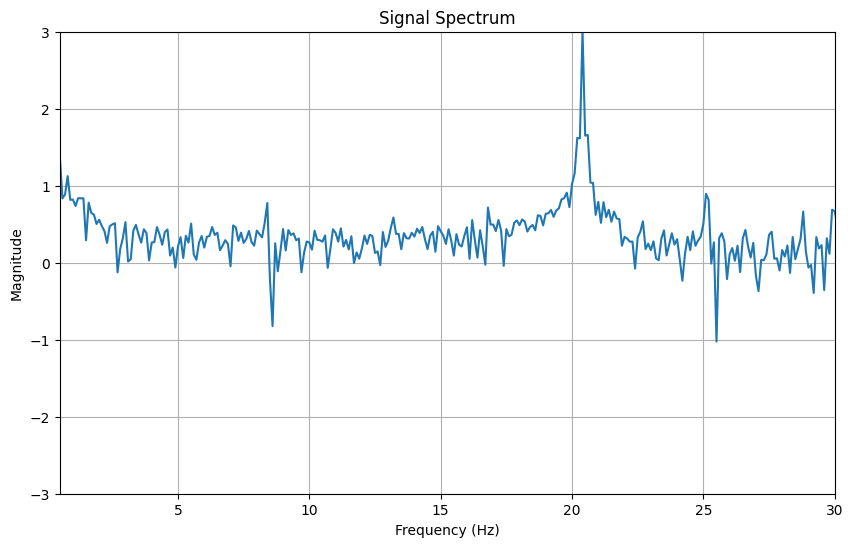

In [14]:
taps = fir_bandstop(201, 15, 25, SAMPLE_RATE)
filtered_FIR_signal = lfilter(taps, 1.0, signal)
plot_signal_spectrum(filtered_FIR_signal, SAMPLE_RATE)

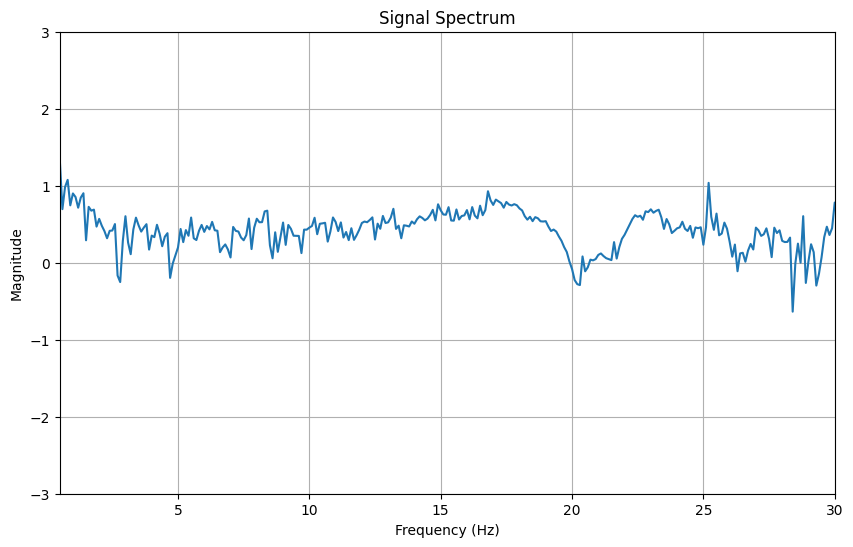

In [51]:
import numpy as np
from scipy.signal import firwin, lfilter, freqz
import matplotlib.pyplot as plt

fs = SAMPLE_RATE
numtaps = 8001  # Можно увеличить для более глубокого подавления

# signal = np.array([...])  # Ваш сигнал

# Создаём FIR band-stop фильтр
taps = firwin(numtaps, [lowcut, highcut], pass_zero=True, fs=fs)

# Применяем фильтр к сигналу
filtered_signal = lfilter(taps, 1.0, signal)

plot_signal_spectrum(filtered_signal, SAMPLE_RATE)